## Neuroevolution of CNN architectures

### Must Remember Points:
**Output dimension = W-F+2P/S + 1 is needed to calculate the input to the Linear layer**  
**If the output size ends up with a decimal ending it is floored to the nearest integer (13.5 --> 13)**  
**CONV --> RELU --> Dropout is the normally followed configuration**  
**Dense --> RELU --> Dropout is the norm**  
**Subset and sampler are to ways to effectively split data**  
**When taking model to production check for weight initializers in the pytorch resnet implementation Github**


## Loading the Dataset 

In [2]:
import torch 
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection

In [3]:
num_workers = 0

batch_size = 50

transform = transforms.ToTensor()

In [4]:
# #Splitting into only train and test datasets
# train_dataset = datasets.MNIST(root='data',train=True,download=True,transform=transform)
# test_dataset = datasets.MNIST(root='data',train=False,download=True,transform=transform)

# trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers)
# testloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,num_workers=num_workers)

In [5]:
# #Alternate method for creating trainloader with stratified sampling
# train_subset = torch.utils.data.Subset(train_dataset,train_idx)
# train_loader = torch.utils.data.DataLoader(tr,batch_size=batch_size)

In [6]:
train_dataset = datasets.MNIST(root='data',train=True,download=False,transform=transform)
test_dataset = datasets.MNIST(root='data',train=False,download=False,transform=transform)

In [7]:
targets = train_dataset.targets

train_idx, valid_idx= model_selection.train_test_split(np.arange(len(targets)),test_size=0.25,shuffle=True,stratify=targets)

In [8]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,num_workers=num_workers)

In [9]:
# #Counting the train loader label instances per batch
# images,labels = next(iter(train_loader))
# set(labels.numpy())
# print([list(labels.numpy()).count(i) for i in set(labels.numpy()) ])
# labels

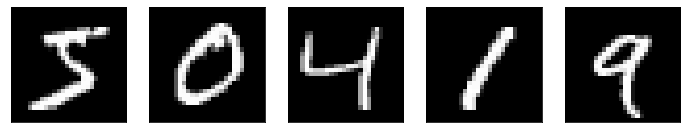

In [10]:
fig = plt.figure(figsize=(12,4))
for i in range(5):
    a = train_dataset[i]
    img = np.squeeze(a[0]) 
    ax = plt.subplot(1,5, i+1,xticks=[],yticks=[])
    ax.imshow(img, cmap='gray')

In [11]:
tr_images, tr_labels= next(iter(train_loader))
val_images, val_labels = next(iter(valid_loader))
te_images, te_labels= next(iter(test_loader))

print("Train loader batch - " + str(list(tr_images.shape)))
print("Train loader batches - " + str(len(train_loader)))
print("Validation loader batch - "+ str(list(val_images.shape)))
print("Validation loader batches - "+ str(len(valid_loader)))
print("Test loader batch - " + str(list(te_images.shape)))
print("Test loader batches - " + str(len(test_loader)))

Train loader batch - [50, 1, 28, 28]
Train loader batches - 900
Validation loader batch - [50, 1, 28, 28]
Validation loader batches - 300
Test loader batch - [50, 1, 28, 28]
Test loader batches - 200


## Defining the training routine

In [22]:
def train(model,optimizer,loss_fun,trainloader,validloader,epochs=10,device="cuda"):
    
    if torch.cuda.is_available:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    model.to(device)
    
    tr_list = []
    val_list = []
    acc_list = []
    epoch_list = [i+1 for i in range(epochs)]
    
    for epoch in range(epochs):
        
        training_loss = 0
        validation_loss = 0
        model.train()                #--------------------->Allows for parameters to be updated by backpropagation
        
        for batch in trainloader:
            
            optimizer.zero_grad()
            inputs,labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs,labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
        
        model.eval()              #------------------------>Freezes the parameters for model validation
        correct_pred = 0
        total_pred = 0
        
        for batch in validloader:
            
            inputs,labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs,labels)
            
            validation_loss +=loss.item()
            
            ps = torch.exp(outputs)         #-------------->The final activation function is Log_Softmax that's why we take exp
            
            correct = torch.eq(torch.max(ps,dim=1)[1],labels).view(-1)
            
            correct_pred += torch.sum(correct).item()
            total_pred += correct.shape[0]       #--------->Alternatively can also write batch.shape[0]
            
        training_loss = training_loss/len(trainloader)
        validation_loss = validation_loss/len(validloader)
        
        tr_list.append(training_loss)
        val_list.append(validation_loss)
        acc_list.append((correct_pred*100.0/total_pred))
            
        print("Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}"
              .format(epoch+1, training_loss,validation_loss, correct_pred * 100.0 / total_pred))
    
    fig = plt.figure(figsize=(20,6))
        
    plt.subplot(1,3,1)
    plt.plot(epoch_list,tr_list)
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    
    plt.subplot(1,3,2)
    plt.plot(epoch_list,val_list)
    plt.title("Validation Loss")
    plt.xlabel("Epochs")
    
    plt.subplot(1,3,3)
    plt.plot(epoch_list,acc_list)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    
    plt.show()

In [ ]:
def train(model,optimizer,loss_fun,trainloader,validloader,epochs=10,device="cuda"):
    
    if torch.cuda.is_available:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    model.to(device)
    
    tr_list = []
    val_list = []
    acc_list = []
    epoch_list = [i+1 for i in range(epochs)]
    
    for epoch in range(epochs):
        
        training_loss = 0
        validation_loss = 0
        model.train()                #--------------------->Allows for parameters to be updated by backpropagation
        
        for batch in trainloader:
            
            optimizer.zero_grad()
            inputs,labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs,labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
        
        model.eval()              #------------------------>Freezes the parameters for model validation
        correct_pred = 0
        total_pred = 0
        
        for batch in validloader:
            
            inputs,labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs,labels)
            
            validation_loss +=loss.item()
            
            ps = torch.exp(outputs)         #-------------->The final activation function is Log_Softmax that's why we take exp
            
            correct = torch.eq(torch.max(ps,dim=1)[1],labels).view(-1)
            
            correct_pred += torch.sum(correct).item()
            total_pred += correct.shape[0]       #--------->Alternatively can also write batch.shape[0]
            
        training_loss = training_loss/len(trainloader)
        validation_loss = validation_loss/len(validloader)
        
        tr_list.append(training_loss)
        val_list.append(validation_loss)
        acc_list.append((correct_pred*100.0/total_pred))
            
        print("Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}"
              .format(epoch+1, training_loss,validation_loss, correct_pred * 100.0 / total_pred))
    
    fig = plt.figure(figsize=(20,6))
        
    plt.subplot(1,3,1)
    plt.plot(epoch_list,tr_list)
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    
    plt.subplot(1,3,2)
    plt.plot(epoch_list,val_list)
    plt.title("Validation Loss")
    plt.xlabel("Epochs")
    
    plt.subplot(1,3,3)
    plt.plot(epoch_list,acc_list)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    
    plt.show()

In [39]:
def test(model,testloader,device="cuda"):
    
    if torch.cuda.is_available:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    model.to(device)
    
    acc_list = []
        
    model.eval()              #------------------------>Freezes the parameters for model validation
    correct_pred = 0
    total_pred = 0
        
    for batch in testloader:
            
        inputs,labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
            
        ps = torch.exp(outputs)         #-------------->The final activation function is Log_Softmax that's why we take exp
            
        correct = torch.eq(torch.max(ps,dim=1)[1],labels).view(-1)
        
        correct_pred += torch.sum(correct).item()
        total_pred += correct.shape[0]       #--------->Alternatively can also write batch.shape[0]
        
        acc_list.append((correct_pred*100.0/total_pred))
        
    print("Test set accuracy: " + str(sum(acc_list)/len(acc_list)))

## 1)Vanilla CNN

In [24]:
class Vanilla_CNN_Model(nn.Module):
    
    def __init__(self):
        
        super().__init__()
                                                    #------------>Input size = 28x28x1
        self.conv1 = nn.Conv2d(1,16,3,padding=1)    #------------>Output size = 28x28x16 (If continuous convolution 
        self.conv2 = nn.Conv2d(16,32,3,padding=1)   #------------>Output size = 28x28x32  operations without pooling
        #self.conv3 = nn.Conv2d(32,64,3,padding=1)   #------------>Output size = 28x28x64  then this would be the output size)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(7*7*32,500)            #------------>Input size = 7x7x32  
        self.output = nn.Linear(500,10)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self,x):
        
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        
        x = x.view(-1,7*7*32)
        
        x = self.dropout(torch.relu(self.fc1(x)))
        x = torch.log_softmax(self.output(x),dim=1)
            
        return x

In [32]:
vanilla_cnn = Vanilla_CNN_Model()
vanilla_cnn_optimizer = torch.optim.Adam(vanilla_cnn.parameters(),lr=0.03)
vanilla_cnn_criterion = nn.NLLLoss()

Epoch: 1, Training Loss: 0.49, Validation Loss: 0.25, accuracy = 92.86
Epoch: 2, Training Loss: 0.32, Validation Loss: 0.26, accuracy = 93.53
Epoch: 3, Training Loss: 0.31, Validation Loss: 0.25, accuracy = 92.67
Epoch: 4, Training Loss: 0.31, Validation Loss: 0.24, accuracy = 93.78
Epoch: 5, Training Loss: 0.33, Validation Loss: 0.25, accuracy = 94.27
Epoch: 6, Training Loss: 0.33, Validation Loss: 0.26, accuracy = 92.91
Epoch: 7, Training Loss: 0.33, Validation Loss: 0.36, accuracy = 92.37
Epoch: 8, Training Loss: 0.33, Validation Loss: 0.24, accuracy = 94.30
Epoch: 9, Training Loss: 0.34, Validation Loss: 0.28, accuracy = 92.47
Epoch: 10, Training Loss: 0.36, Validation Loss: 0.26, accuracy = 94.25


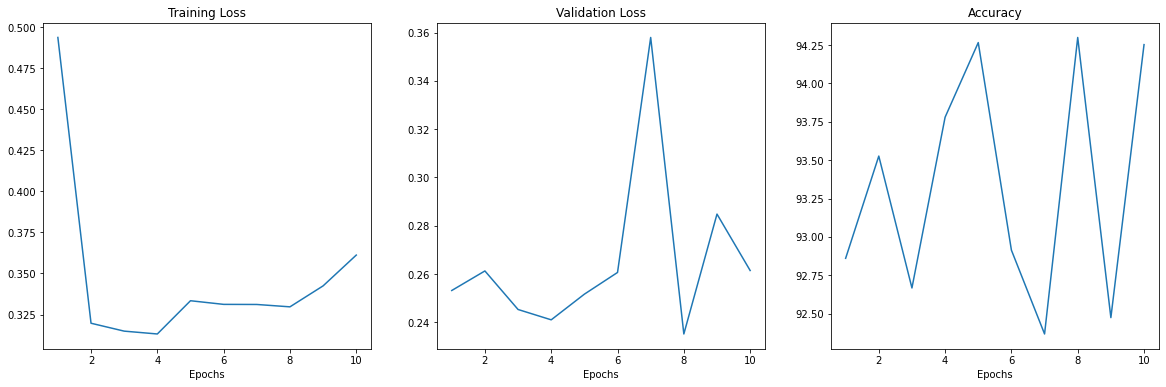

In [33]:
train(vanilla_cnn,vanilla_cnn_optimizer,vanilla_cnn_criterion,train_loader,valid_loader)

In [34]:
test(vanilla_cnn,test_loader)

Test set accuracy: 94.05974510559807


## 2)Neuroevolution for Vanilla CNN

Will be using the block encoding technique with predefined parameters  
**If padding P = F-1/2 then input and output size is the same, we will be using this so that output dimension reduces only 
due to the pooling operation and not during the convolution stages**

### Network Architecture

In [40]:
import random
import math

In [41]:
N = 50
noise = 0.3

X_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_train = X_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

X_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_test = X_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

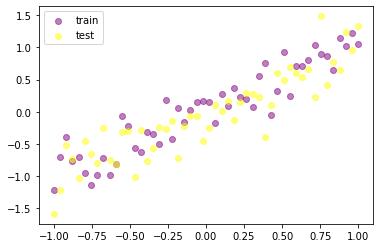

In [42]:
plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

In [43]:
N_h = 100

model_dropout = nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

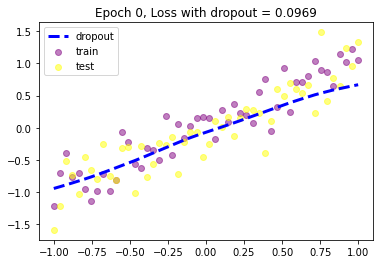

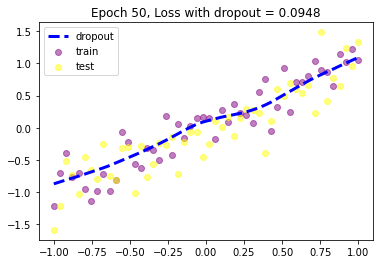

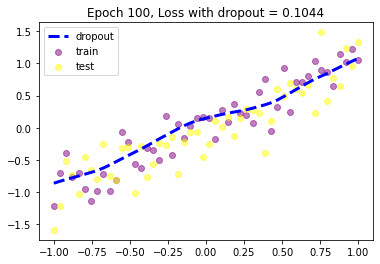

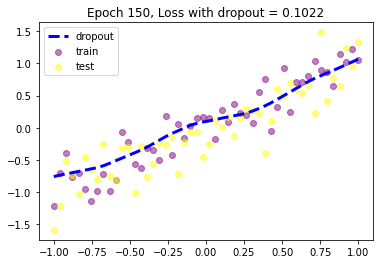

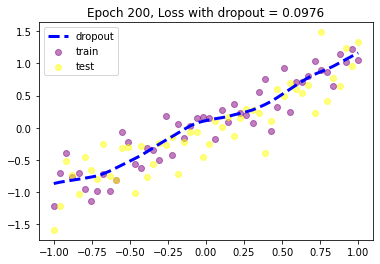

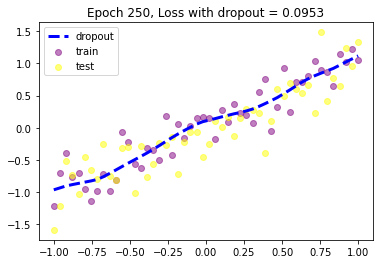

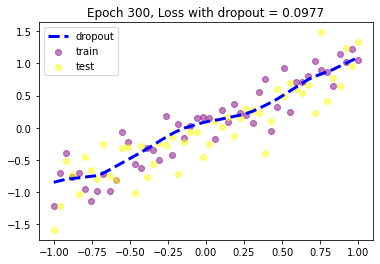

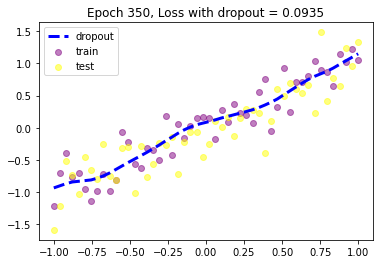

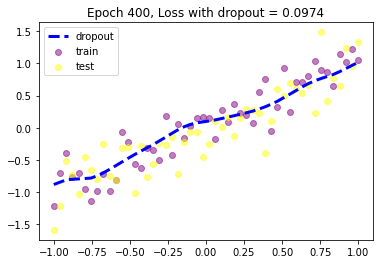

In [44]:
max_epochs = 401

for epoch in range(max_epochs):
    
    # look at the entire data in a single shot
       
    pred_dropout = model_dropout(X_train)
    loss_dropout = loss_fn(pred_dropout, Y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()
    
    
    if epoch % 50 == 0:
        
        model_dropout.eval()
        
        test_pred_dropout = model_dropout(X_test)
        test_loss_dropout = loss_fn(test_pred_dropout, Y_test)
        
        plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(), 'b--', lw=3,  label='dropout')
        
        plt.title('Epoch %d, Loss with dropout = %0.4f' % (epoch, test_loss_dropout))
        
        plt.legend()

        model_dropout.train()
        
        plt.pause(0.05)

In [45]:
# l = [i for i in range(16)]
# for i in range(0,len(l)-2,7):
#     print(i)

# class Mod(nn.Module):
     
#     def __init__(self):
        
#         super().__init__()
        
#         #self.seq = nn.Sequential(nn.Linear(1,1))
        
#         self.
        
#         self.model_dropout = nn.Sequential(
#     torch.nn.Linear(2, N_h),
#     torch.nn.Dropout(0.2),
#     torch.nn.ReLU(),
#     torch.nn.Linear(N_h, N_h),
#     torch.nn.Dropout(0.2),
#     torch.nn.ReLU(),
#     torch.nn.Linear(N_h, 1))
        
#         #self.seq.add_module("Add-on",self.model_dropout)
        
#         self.add_module("Add-on",self.model_dropout)
        
        
#     def forward(self,x):
        
#         x = self.Mod(x)
        
#         return x

# model = Mod()
# model

In [46]:
def convert_cnn_block_parameters(param_list):
    
    """Converts the conv block parameters not the optimizer and learning rate from the chromosome"""
    
    #Parameters = [Block act, No of conv, No. of filters, Filter size, Dropout, Pooling, Activation fn.]
    
    num_of_filters     = [8,16,32,64]
    filter_sizes       = [3,5,7]
    pooling_strategies = ['MaxPool2d','AvgPool2d']
    activation_funs    = ['ReLU','Tanh','LeakyReLU']

    conv_layers  =  round(param_list[1])
    num_filters  =  num_of_filters[math.floor(param_list[2])]
    filter_dim   =  filter_sizes[math.floor(param_list[3])]
    dropout_prob =  param_list[4]
    pooling      =  pooling_strategies[round(param_list[5])]
    activation   =  activation_funs[math.floor(param_list[6])]
    
    return conv_layers, num_filters, filter_dim, dropout_prob, pooling, activation

In [47]:
class Neuro_Vanilla_CNN_Model(nn.Module):
    
    def __init__(self,network_params,input_size,input_channels):
        
        super().__init__()
        
        self.input_size       = input_size         #----->Fixed instance variable 

        self.input_channels   = input_channels     #----->Fixed instance variable
        
        self.conv_blocks      = nn.Sequential()
        
        self.current_size     = input_size         #------>Instance variable changes with each conv block 
        
        self.current_channels = input_channels     #------>Instance variable changes with each conv block
        
        for block_idx in range(0,len(network_params)-2,7):  #----->Accesses 1st indice of each conv block (Excluding last 2 parameters) 
            
            if round(network_params[block_idx])==1:
                
                self.conv_blocks.add_module("Conv_Block " + str(block_idx//7 + 1),
                                            self.create_conv_block(network_params[block_idx:block_idx+7]))
    
        self.fc1 = nn.Linear(self.current_size*self.current_size*self.current_channels,400)      
        
        self.output = nn.Linear(400,10)
        
        self.dropout = nn.Dropout(0.3)
    
    def create_conv_block(self,params):
        
        #Parameters = [Block act, No of conv, No. of filters, Filter size, Dropout, Pooling, Activation fn.]
        #Number of filters and filter size is same for both convolutional layers if present
        
        num_conv_layer, num_filters, filter_size, dropout_prob, pooling_strategy, activation_fn = convert_cnn_block_parameters(params)               
        
        cnn_block    = nn.Sequential()
        
        padding_size = (filter_size - 1) // 2       #----->Calculated so that input size equal to ouptut size
    
        for layers in range(1,num_conv_layer+1):
            
            cnn_block.add_module("Conv_layer" + str(layers),nn.Conv2d(in_channels=self.current_channels,out_channels=num_filters,
                                                                      kernel_size=filter_size,stride=1,padding=padding_size))
            
            self.current_channels = num_filters
            
            cnn_block.add_module("Activation" + str(layers),nn.__getattribute__(activation_fn)())
            
        cnn_block.add_module("Dropout",nn.Dropout2d(p=dropout_prob))
        
        cnn_block.add_module("Pooling",nn.__getattribute__(pooling_strategy)(2,2))
        
        self.current_size //= 2 
        
        return cnn_block
    
    def forward(self,x):

        x = self.conv_blocks(x)
        
        x = x.view(-1,self.current_size*self.current_size*self.current_channels)
        
        x = self.dropout(torch.relu(self.fc1(x)))
        x = torch.log_softmax(self.output(x),dim=1)
            
        return x

In [201]:
def get_accuracy(params_list,input_size,input_channels):
    
    """The function takes the input of the floating number encoded chromosome and returns the accuracy as the output"""
      
    classifier = Neuro_Vanilla_CNN_Model(params_list,input_size,input_channels)
    
    if torch.cuda.is_available:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    classifier.to(device)

    loss_function = nn.NLLLoss()
    
    optimizers = ['Adam','Adagrad','Adadelta','RMSprop']
    
    opt = torch.optim.__getattribute__(optimizers[math.floor(params_list[-2])])
    
    optimizer = opt(classifier.parameters(),lr=params_list[-1])
    
    accuracy = train_ga(classifier,optimizer,loss_function,train_loader,valid_loader,epochs=4)
    
    #return sum(accuracy)/len(accuracy)
    
    return accuracy

In [202]:
def train_ga(model,optimizer,loss_fun,trainloader,testloader,epochs=15,device="cuda"):

    acc_list = []
    
    for epoch in range(epochs):
        
        model.train()                #--------------------->Allows for parameters to be updated by backpropagation
        
        for batch in trainloader:
            
            optimizer.zero_grad()
            inputs,labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs,labels)
            loss.backward()
            optimizer.step()
        
        model.eval()              #------------------------>Freezes the parameters for model validation
        correct_pred = 0
        total_pred = 0
        
        for batch in testloader:
            
            inputs,labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            ps = torch.exp(outputs)         #-------------->The final activation function is Log_Softmax that's why we take exp
            
            correct = torch.eq(torch.max(ps,dim=1)[1],labels).view(-1)
            
            correct_pred += torch.sum(correct).item()
            total_pred += correct.shape[0]       #--------->Alternatively can also write batch.shape[0]

        acc_list.append((correct_pred*100.0/total_pred))
    
    return acc_list

### Genetic Representation and Solution

In [49]:
from deap import tools
from deap import base
from deap import creator
import random
import elitism
import numpy as np
import seaborn as sns

In [78]:
BOUNDS_CNN_LOW  = [0 , 1 , 0 , 0 , 0   , 0 , 0]
BOUNDS_CNN_HIGH = [1 , 2 , 4 , 3 , 0.5 , 1 , 3]

In [80]:
BOUNDS_OPTIMIZER_LOW  = [0 , 0     ]
BOUNDS_OPTIMIZER_HIGH = [4 , 0.09  ]

In [216]:
NUM_OF_CNN_PARAMS = 7
NUM_OF_BLOCKS     = 2
POPULATION_SIZE   = 10
P_CROSSOVER       = 0.9
P_MUTATION        = 0.2
MAX_GENERATIONS   = 5
HALL_OF_FAME_SIZE = 2
CROWDING_FACTOR   = 10.0
NUM_OF_PARAMS     = NUM_OF_BLOCKS*NUM_OF_CNN_PARAMS + 2 

In [205]:
BOUNDS_LOW  = BOUNDS_CNN_LOW*NUM_OF_BLOCKS  + BOUNDS_OPTIMIZER_LOW
BOUNDS_HIGH = BOUNDS_CNN_HIGH*NUM_OF_BLOCKS + BOUNDS_OPTIMIZER_HIGH

In [52]:
creator.create("FitnessMax",base.Fitness,weights=(1.0,))
creator.create("Individual",list,fitness=creator.FitnessMax)

In [85]:
toolbox = base.Toolbox()
for i in range(NUM_OF_CNN_PARAMS):
    toolbox.register("attribute_"+str(i),random.uniform,BOUNDS_CNN_LOW[i],BOUNDS_CNN_HIGH[i])

In [86]:
cnn_attributes = ()
for i in range(NUM_OF_CNN_PARAMS):
    cnn_attributes += (toolbox.__getattribute__("attribute_"+str(i)),)

In [87]:
toolbox.register("attribute_optim1",random.uniform,BOUNDS_OPTIMIZER_LOW[0],BOUNDS_OPTIMIZER_HIGH[0])
toolbox.register("attribute_optim2",random.uniform,BOUNDS_OPTIMIZER_LOW[1],BOUNDS_OPTIMIZER_HIGH[1])

In [88]:
optim_attributes = (toolbox.attribute_optim1,toolbox.attribute_optim2)

In [56]:
# add_attributes = (toolbox.add1,toolbox.add2,)

# a = [1,24,4]
# b = tools.initCycle(list,add_attributes)

In [158]:
def dummy():
    dummy_list = tools.initCycle(list,attributes,n=NUM_OF_BLOCKS)
    extend_list = tools.initCycle(list,optim_attributes)
    return dummy_list + extend_list

In [90]:
# #Creation of only the CNN block parameters
# toolbox.register("individualCreator",tools.initCycle,creator.Individual,attributes,n=NUM_OF_BLOCKS)
# toolbox.register("populationCreator",tools.initRepeat,list,toolbox.individualCreator)

In [159]:
# Creation of all the parameters including optimizers

toolbox.register("individualCreator",tools.initIterate,creator.Individual,dummy)
toolbox.register("populationCreator",tools.initRepeat,list,toolbox.individualCreator)

In [184]:
def convert_params(individual):
    
    """Converts all the chromosome genes into interpretable parameters"""
    
    parameters = []

    num_of_filters     = [8,16,32,64]
    filter_sizes       = [3,5,7]
    pooling_strategies = ['MaxPool2d','AvgPool2d']
    activation_funs    = ['ReLU','Tanh','LeakyReLU']
    optimizers         = ['Adam','Adagrad','Adadelta','RMSprop']
    
    for idx in range(0,len(individual)-2,7):
    
        conv_active  =  round(individual[idx])
        conv_layers  =  round(individual[idx + 1])
        num_filters  =  num_of_filters[math.floor(individual[idx+2])]
        filter_dim   =  filter_sizes[math.floor(individual[idx+3])]
        dropout_prob =  individual[idx+4]
        pooling      =  pooling_strategies[round(individual[idx+5])]
        activation   =  activation_funs[math.floor(individual[idx+6])]
        
        parameters.append([conv_active,conv_layers,num_filters,filter_dim,dropout_prob,pooling,activation])
        
    optimizer     = optimizers[math.floor(individual[-2])]
    learning_rate = individual[-1] 
    
    parameters.append([optimizer,learning_rate])
    
    return parameters

In [189]:
# mod = Neuro_Vanilla_CNN_Model(sample,28,1)
# mod

# convert_params(sample)

# mod_optimizer = torch.optim.Adam(mod.parameters(),lr=0.03,)
# mod_criterion = nn.NLLLoss()

# train(mod,mod_optimizer,mod_criterion,train_loader,valid_loader,epochs=4)

In [214]:
def classification_accuracy(individual):
    accuracy = get_accuracy(individual,input_size=28,input_channels=1)
    return sum(accuracy)/len(accuracy),
    
toolbox.register("evaluate",classification_accuracy)

In [208]:
toolbox.register("select",tools.selTournament,tournsize=2)
toolbox.register("mate",tools.cxSimulatedBinaryBounded,low=BOUNDS_LOW,up=BOUNDS_HIGH,eta=CROWDING_FACTOR)
toolbox.register("mutate",tools.mutPolynomialBounded,low=BOUNDS_LOW,up=BOUNDS_HIGH,eta=CROWDING_FACTOR,indpb=1.0/NUM_OF_PARAMS)

In [212]:
def main():
    
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)


    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    population, logbook = elitism.eaSimpleWithElitism(population,toolbox,cxpb=P_CROSSOVER,mutpb=P_MUTATION,ngen=MAX_GENERATIONS,
                                                      stats=stats,halloffame=hof,verbose=True)



    # print best solution found:

    print("- Best solutions are:")
    for i in range(HALL_OF_FAME_SIZE):
        print(i, ": ", hof.items[i].fitness.values[0], " -> ", convert_params(hof.items[i]))


    # plot statistics:

    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
    plt.figure(1)
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average fitness over Generations')
    
    print("- Best solution is: \n",(convert_params(hof.items[0])),"\n => accuracy = ",hof.items[0].fitness.values[0])

gen	nevals	max    	avg    
0  	5     	97.4533	79.2917
1  	4     	97.6683	96.823 
2  	2     	97.7117	97.0967
- Best solutions are:
0 :  97.66833333333334  ->  [[1, 1, 32, 3, 0.1417091826050545, 'AvgPool2d', 'Tanh'], [1, 1, 8, 5, 0.15087961512449505, 'AvgPool2d', 'LeakyReLU'], ['Adagrad', 0.0407051927418396]]
- Best solution is: 
 [[1, 1, 32, 3, 0.1417091826050545, 'AvgPool2d', 'Tanh'], [1, 1, 8, 5, 0.15087961512449505, 'AvgPool2d', 'LeakyReLU'], ['Adagrad', 0.0407051927418396]] 
 => accuracy =  97.66833333333334


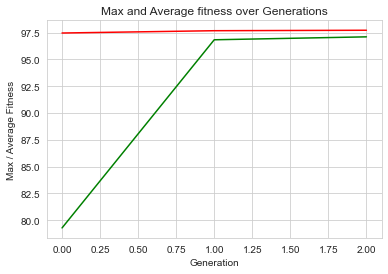

In [215]:
main()

gen	nevals	max   	avg    
0  	10    	98.345	70.0157
1  	6     	98.345	85.0775
2  	8     	98.345	97.1663
3  	8     	98.4367	95.6195
4  	7     	98.455 	97.818 
5  	5     	98.4817	97.9892
- Best solutions are:
0 :  98.48166666666668  ->  [[0, 2, 8, 5, 0.4859412881532458, 'AvgPool2d', 'ReLU'], [1, 1, 32, 5, 0.08388211160401288, 'MaxPool2d', 'ReLU'], ['Adagrad', 0.04595963510078348]]
1 :  98.455  ->  [[0, 2, 8, 7, 0.4855448482624286, 'AvgPool2d', 'ReLU'], [1, 2, 32, 5, 0.08328097252107046, 'MaxPool2d', 'ReLU'], ['Adagrad', 0.019831011015659306]]
- Best solution is: 
 [[0, 2, 8, 5, 0.4859412881532458, 'AvgPool2d', 'ReLU'], [1, 1, 32, 5, 0.08388211160401288, 'MaxPool2d', 'ReLU'], ['Adagrad', 0.04595963510078348]] 
 => accuracy =  98.48166666666668


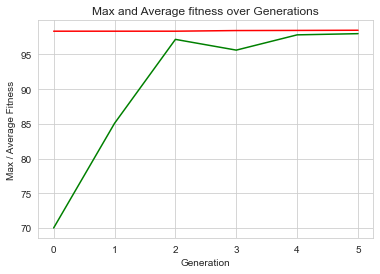

In [217]:
main()

In [219]:
sample=[0, 2, 0 , 1, 0.4859412881532458, 1, 0, 1, 1, 2, 1, 0.08388211160401288, 0, 0, 1 , 0.04595963510078348]
convert_params(sample)

[[0, 2, 8, 5, 0.4859412881532458, 'AvgPool2d', 'ReLU'],
 [1, 1, 32, 5, 0.08388211160401288, 'MaxPool2d', 'ReLU'],
 ['Adagrad', 0.04595963510078348]]

In [220]:
# num_of_filters     = [8,16,32,64]
# filter_sizes       = [3,5,7]
# pooling_strategies = ['MaxPool2d','AvgPool2d']
# activation_funs    = ['ReLU','Tanh','LeakyReLU']
# optimizers         = ['Adam','Adagrad','Adadelta','RMSprop']
trial_cnn = Neuro_Vanilla_CNN_Model(sample,28,1)
trial_cnn

Neuro_Vanilla_CNN_Model(
  (conv_blocks): Sequential(
    (Conv_Block 2): Sequential(
      (Conv_layer1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (Activation1): ReLU()
      (Dropout): Dropout2d(p=0.08388211160401288, inplace=False)
      (Pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc1): Linear(in_features=6272, out_features=400, bias=True)
  (output): Linear(in_features=400, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Epoch: 1, Training Loss: 0.39, Validation Loss: 0.07, accuracy = 97.74
Epoch: 2, Training Loss: 0.07, Validation Loss: 0.05, accuracy = 98.43
Epoch: 3, Training Loss: 0.05, Validation Loss: 0.05, accuracy = 98.56
Epoch: 4, Training Loss: 0.04, Validation Loss: 0.04, accuracy = 98.72
Epoch: 5, Training Loss: 0.03, Validation Loss: 0.04, accuracy = 98.69
Epoch: 6, Training Loss: 0.02, Validation Loss: 0.04, accuracy = 98.82
Epoch: 7, Training Loss: 0.02, Validation Loss: 0.04, accuracy = 98.93
Epoch: 8, Training Loss: 0.02, Validation Loss: 0.04, accuracy = 98.96


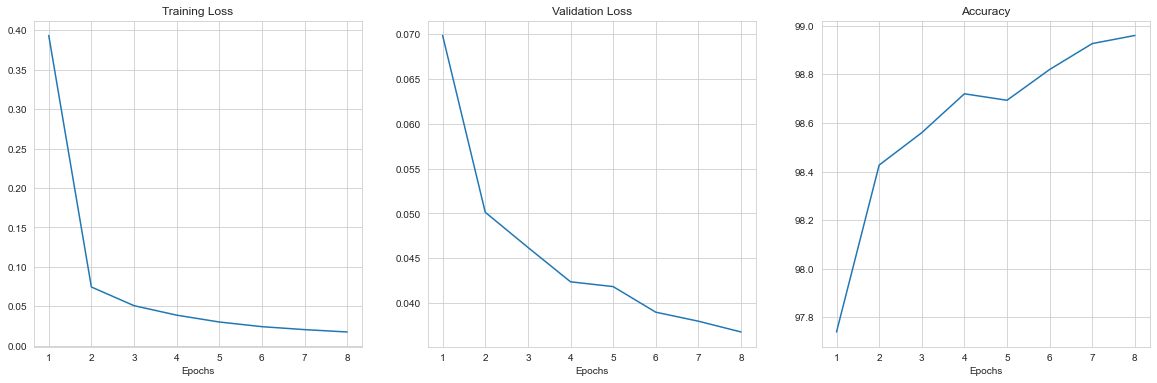

In [223]:
trial_cnn_optimizer = torch.optim.Adagrad(trial_cnn.parameters(),lr=0.04595963510078348)
trial_cnn_criterion = nn.NLLLoss()

train(trial_cnn,trial_cnn_optimizer,trial_cnn_criterion,train_loader,valid_loader,epochs=8)

In [224]:
test(trial_cnn,test_loader)

Test set accuracy: 98.70484513220117
